In [18]:
import zipfile as ZipFile
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from sklearn.model_selection import train_test_split

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
train_image = "/content/drive/MyDrive/Tamil Dataset/Tamil Uriye Eluthukal/train-image-1591211703.9039922.npy"
train_label = "/content/drive/MyDrive/Tamil Dataset/Tamil Uriye Eluthukal/train-label-1591211706.368335-onehot.npy"

In [21]:
train_X = np.load(train_image)
train_y = np.load(train_label)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [23]:
X_train.shape,y_train.shape

((48000, 784), (48000, 13))

In [24]:
X_test.shape,y_test.shape

((12000, 784), (12000, 13))

[0 0 0 1 0 0 0 0 0 0 0 0 0]
3


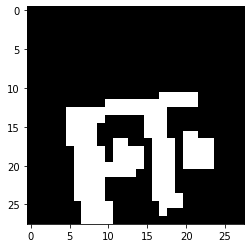

In [25]:
index = 900
plt.imshow(X_train[index].reshape(28,28),cmap="gray")
print(y_train[index])
print(y_train[index].argmax())

In [26]:
class TamilLang(Dataset):

  def __init__(self,X,y,transform=None):
    self.X = X
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self,index):
    x = Image.fromarray(self.X[index].reshape(28,28))
    y = self.y[index].argmax()

    if self.transform != None:
      x = self.transform(x)
    
    return x,y


In [27]:
transformations =  transforms.Compose([
        transforms.ToTensor(),
])

In [28]:
train_dataset =  TamilLang(X_train,y_train,transformations)
test_dataset = TamilLang(X_test,y_test,transformations)

In [29]:
train_dataset.transform

Compose(
    ToTensor()
)

In [30]:
test_dataset.transform

Compose(
    ToTensor()
)

In [31]:
train_datasetLoader = DataLoader(train_dataset,batch_size=100,shuffle=False)
test_datasetLoader = DataLoader(test_dataset,batch_size=100,shuffle=False)

torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([1, 28, 28])
torch.Size([])
tensor(10)


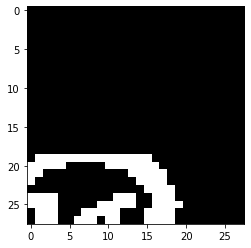

In [32]:
tdl = iter(train_datasetLoader)
tdl = next(tdl)
print(tdl[0].shape) # this is the shape of images along with the batch size (100,1,28,28)
print(tdl[1].shape) # this is the shape of labels along with the batch size (100,13)
print(tdl[0][0].shape) # this is the shape of images alone (1,28,28)
print(tdl[1][0].shape) # this is the shape of label alone
plt.imshow(tdl[0][9].reshape(28,28),cmap="gray") # this is a image
print(tdl[1][9]) # this is the corresponding label

In [33]:
config = [
     # input_channels:int,no.of filters:int,filter_size:int,stride:int,padding:int
     (1,16,3,1,1),
     # MP - max pooling:string,filter_size:int,stride:int,padding:int
     ("MP",2,2,1),
     (16,32,3,1,1),
     ("MP",2,2,0),
     (32,64,3,1,1),
     ("MP",2,2,0),
     (64,128,3,1,1),
     ("MP",2,2,0),
]

In [34]:
def conv_output_size(img_size,padding,filter_size,stride,n_filters):
   size_ = (int((img_size + (2 * padding) - filter_size) / stride)) + 1
   return size_,size_,n_filters

In [35]:
def dense_layer_size(configuration,img_size):

  _,output_channels = 0,0
  layer_count = 0

  for config in configuration:
    
    layer_count += 1

    if config[0] == "MP":
      img_size,_,output_channels = conv_output_size(img_size,config[3],config[1],config[2],output_channels)
      print("Max Pooling Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)

    else: 
      img_size,_,output_channels = conv_output_size(img_size,config[4],config[2],config[3],config[1])
      print("Conv Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)
  
  return img_size,_,output_channels

In [36]:
width,heigth,channels = dense_layer_size(config,28)

Conv Layer 1 output dims ::  28 28 16
Max Pooling Layer 2 output dims ::  15 15 16
Conv Layer 3 output dims ::  15 15 32
Max Pooling Layer 4 output dims ::  7 7 32
Conv Layer 5 output dims ::  7 7 64
Max Pooling Layer 6 output dims ::  3 3 64
Conv Layer 7 output dims ::  3 3 128
Max Pooling Layer 8 output dims ::  1 1 128


In [37]:
width * heigth * channels

128

In [44]:
class NeuralNet(nn.Module):

  def __init__(self):
    super(NeuralNet,self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1,16,3,1,1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(16,32,3,1,1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(32,64,3,1,1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d(64,128,3,1,1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.FC = nn.Sequential(
        nn.Linear(128,13)
    )

  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = torch.flatten(x, 1)
    x = self.FC(x)
    return x


In [45]:
model = NeuralNet()

In [46]:
model.train()
print(model)

NeuralNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Batch

In [47]:
lr = 0.001
loss_fn = nn.CrossEntropyLoss() # reffer this blog https://neptune.ai/blog/pytorch-loss-functions
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [48]:
epochs = 30

all_epochs_loss = []
all_epochs_acc = []

for epoch in range(epochs):

  epoch_loss = 0
  epoch_accuracy = 0

  for batch_id,(image,label) in enumerate(train_datasetLoader):
  
    prediction = model(image)
    loss = loss_fn(prediction,label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = (prediction.argmax(dim=1) == label).float().mean()
    epoch_loss += (loss.item() / len(train_datasetLoader)) * 100
    epoch_accuracy += (acc.item() / len(train_datasetLoader)) * 100
   
    if (batch_id + 1) % 100 == 0:
      all_epochs_loss.append(int(epoch_loss))  
      all_epochs_acc.append(int(epoch_accuracy)) 

  print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))


Epoch : 1, train accuracy : 82.30416662059729, train loss : 45.47559235865865
Epoch : 2, train accuracy : 90.44375022252409, train loss : 20.613807177481565
Epoch : 3, train accuracy : 92.1541669592262, train loss : 16.307379843977596
Epoch : 4, train accuracy : 93.21875017136335, train loss : 13.986177207746849
Epoch : 5, train accuracy : 93.85208340982594, train loss : 12.539595367852593
Epoch : 6, train accuracy : 94.26666674514605, train loss : 11.453949809850496
Epoch : 7, train accuracy : 94.62916669746234, train loss : 10.71945434591423
Epoch : 8, train accuracy : 94.84583345552271, train loss : 10.215208368608735
Epoch : 9, train accuracy : 95.1520833869774, train loss : 9.514131618198004
Epoch : 10, train accuracy : 95.34791689366088, train loss : 8.998415300156926
Epoch : 11, train accuracy : 95.33125021805353, train loss : 8.755406179698188
Epoch : 12, train accuracy : 95.43125023444479, train loss : 8.590505911270157
Epoch : 13, train accuracy : 95.5729169398545, train loss

In [50]:
torch.save(model.state_dict(), "TLModel5_30_1.pt")

In [51]:
with torch.no_grad():
  model.eval()

  epoch_loss = 0
  epoch_accuracy = 0

  acc_list = []
  loss_list = []
  
  for batch_id,(image,label) in enumerate(test_datasetLoader):
    prediction = model(image)
    loss = loss_fn(prediction,label)
    
    acc = (prediction.argmax(dim=1) == label).float().mean()
    epoch_loss += (loss.item() / len(test_datasetLoader)) * 100
    epoch_accuracy += (acc.item() / len(test_datasetLoader)) * 100
   
    if (batch_id + 1) % 100 == 0:
      loss_list.append(int(epoch_loss))  
      acc_list.append(int(epoch_accuracy)) 

  print('test accuracy : {}, test loss : {}'.format(epoch_accuracy,epoch_loss))


test accuracy : 92.04166695475578, test loss : 21.463020822654165


In [52]:
model.eval()

NeuralNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Batch

ground truth ::  10
predicted ::  10


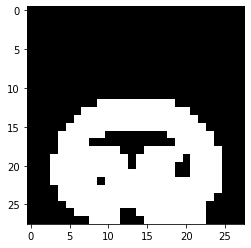

In [55]:

index = 4989

for_testing = transformations(train_X[index].reshape(28,28))
plt.imshow(for_testing.reshape(28,28),cmap="gray")
print("ground truth :: ",train_y[index].argmax() + 1)

predict = model(for_testing[None,...])
print("predicted :: ",predict.argmax(dim=1).item() + 1)